# 1. Full Google Colab Code: Read CSV from GCS into PySpark

## Download Spark and install dependencies

In [ ]:
! pip install pyspark

## Start SparkSession

In [ ]:
!wget https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar -P /content

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ReadFromGCS") \
    .config("spark.jars", "/content/gcs-connector-hadoop3-latest.jar") \
    .getOrCreate()

--2025-05-11 07:09:09--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.129.207, 209.85.200.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.129.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40713341 (39M) [application/java-archive]
Saving to: ‘/content/gcs-connector-hadoop3-latest.jar.1’

gcs-connector-hadoo 100%[===================>]  38.83M  50.4MB/s    in 0.8s    

2025-05-11 07:09:10 (50.4 MB/s) - ‘/content/gcs-connector-hadoop3-latest.jar.1’ saved [40713341/40713341]



In [ ]:
hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
hadoop_conf.set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")

## Authenticate to GCS

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Read CSV from GCS

In [ ]:
gcs_path = "gs://tariff-data-ziqi/reddit_data/df_text_stream.csv"

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(gcs_path)

df.show(5, truncate=False)

+-------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------+----+-------+----------+
|post_id|created_date       |text                                                                                                                                                                                                                                                                    |emotion_label|month  |year|source |date      |
+-------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------+--

In [ ]:
df.printSchema()

root
 |-- post_id: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- emotion_label: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- source: string (nullable = true)
 |-- date: string (nullable = true)



# 2. LDA Topic Modeling with Spark

## Step 0: Filter out null or empty text values before tokenization

In [ ]:
from pyspark.sql.functions import col, length, trim, regexp_replace, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
import numpy as np

In [ ]:
# - Remove null/empty
# - Remove non-letters (dates, symbols, numbers, etc.)
# - Lowercase normalization
df_clean = df.withColumn("clean_text",
    regexp_replace(col("text"), "[^a-zA-Z\s]", "")
).withColumn("clean_text", regexp_replace(col("clean_text"), "\s+", " "))

## Step 1: Tokenization

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_tokenized = tokenizer.transform(df_clean)

##  Step 2: Remove stopwords

In [ ]:
extra_stopwords = [
    "like", "get", "even", "thing", "know", "just", "got", "literally",
    "actually", "fucking", "fuck", "he's", "she's", "they're", "it's",
    "us", "one", "now", "always", "still", "also", "too", "said", "go", "take", "vote"
]
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
remover.setStopWords(remover.getStopWords() + extra_stopwords)
df_filtered = remover.transform(df_tokenized)

## Step 3: Convert to Term Frequency Vectors

In [ ]:
vectorizer = CountVectorizer(
    inputCol="filtered_words",
    outputCol="features",
    vocabSize=3000,
    minDF=10
)
vectorizer_model = vectorizer.fit(df_filtered)
df_vectorized = vectorizer_model.transform(df_filtered)

## Step 4: Fit LDA Model

In [ ]:
lda = LDA(k=5, maxIter=10, featuresCol="features")
lda_model = lda.fit(df_vectorized)

## Step 5: Describe topics (show top 10 words per topic)

In [ ]:
vocab = vectorizer_model.vocabulary
topics = lda_model.describeTopics(10)
topics_words = topics.rdd.map(lambda row: [vocab[i] for i in row.termIndices]).collect()

for i, words in enumerate(topics_words):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: trade, need, american, don’t, time, think, people, good, first, 
Topic 1: , it’s, people, prices, never, least, come, bad, two, make
Topic 2: neutral, anger, , going, best, made, news, fox, someone, little
Topic 3: trump, tariffs, people, think, going, canada, 2025-03, really, every, it.
Topic 4: , 2025-04, 2025-02, trump, make, tariffs, never, ever, people, say


## Step 6: Topic Distribution per Document

In [ ]:
def get_main_topic(distribution):
    return int(np.argmax(distribution))

get_main_topic_udf = udf(get_main_topic, IntegerType())
df_topics = lda_model.transform(df_vectorized).withColumn("main_topic", get_main_topic_udf(col("topicDistribution")))

In [ ]:
df_topics.select("post_id", "main_topic", "topicDistribution").show(truncate=False)

+-------------------------------------------+----------+-------------------------------------------------------------------------------------------------------+
|post_id                                    |main_topic|topicDistribution                                                                                      |
+-------------------------------------------+----------+-------------------------------------------------------------------------------------------------------+
|1ff3qfr                                    |4         |[0.02760238569945014,0.027810757937816195,0.027369834629040406,0.030508088439670514,0.8867089332940227]|
|1ff3qfr                                    |0         |[0.8862905636445555,0.02794648047063406,0.02697039735686102,0.030731748201480447,0.028060810326468844] |
|1ff3qfr                                    |1         |[0.06470735883493185,0.42078231363054525,0.06497735016267334,0.38404082573466414,0.06549215163718543]  |
|1ff3qfr                          

convert to Pandas for further analysis

In [ ]:
import pandas as pd

pandas_df = df_topics.select("post_id", "topicDistribution").toPandas()
topic_matrix = pd.DataFrame(pandas_df["topicDistribution"].tolist(), columns=[f"Topic_{i}" for i in range(5)])
final_df = pd.concat([pandas_df["post_id"], topic_matrix], axis=1)

## Step 7: Topic Keyword Visualization (Word Cloud)

In [ ]:
# Get term weights and map to words
topics_df = topics.toPandas()
vocab = vectorizer_model.vocabulary

topic_id = 0  # choose topic to visualize
words = [vocab[i] for i in topics_df.loc[topic_id, "termIndices"]]
weights = topics_df.loc[topic_id, "termWeights"]

word_weight_dict = dict(zip(words, weights))

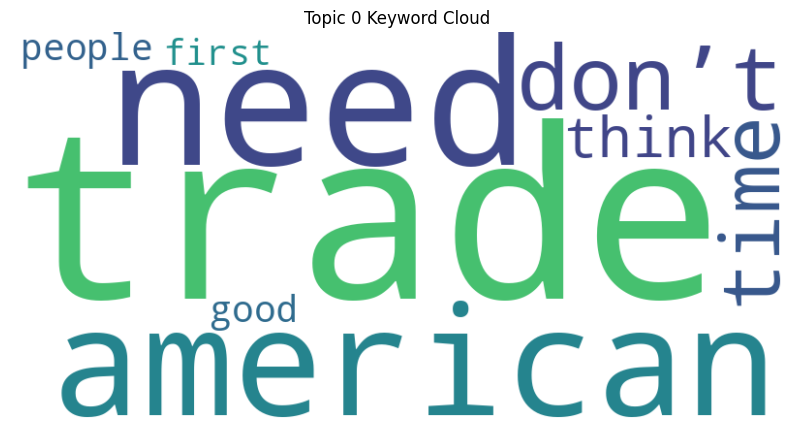

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=800, height=400, background_color="white")
wc.generate_from_frequencies(word_weight_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"Topic {topic_id} Keyword Cloud")
plt.show()

# 3.LDA Topic Modeling with Pandas scikit-learn

## Step 1: Import Libraries

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Step 2: Read CSV from Google Cloud Storage

In [ ]:
import pandas as pd

gcs_path = "gs://tariff-data-ziqi/reddit_data/df_text_stream.csv"

# Use pandas + GCS to read
df = pd.read_csv(gcs_path)

# Check
df.head()

,post_id,created_date,text,emotion_label,month,year,source,date
0,1ff3qfr,2024-09-12 14:20:07,[OC] Visualization of which presidential candi...,neutral,2024-09,2024,comment,2024-09-12
1,1ff3qfr,2024-09-12 14:23:40,"That was my biggest gripe with ABC, halfway th...",anger,2024-09,2024,comment,2024-09-12
2,1ff3qfr,2024-09-12 14:25:22,BuT iT wAs ThReE oN one!!!!!! /s,neutral,2024-09,2024,comment,2024-09-12
3,1ff3qfr,2024-09-12 14:26:54,They even aggressively stopped her the one tim...,neutral,2024-09,2024,comment,2024-09-12
4,1ff3qfr,2024-09-12 14:30:03,I hate that making basic statements like “peop...,disgust,2024-09,2024,comment,2024-09-12


## Step 3: Text Preprocessing

In [ ]:
# Drop null or empty entries
df = df[df["text"].notnull() & df["text"].str.strip().astype(bool)]

# Set of stopwords (standard + custom)
extra_stopwords = {
    "like", "get", "even", "thing", "know", "just", "got", "literally",
    "actually", "fucking", "fuck", "he's", "it's", "they're", "us", "one",
    "now", "also", "said", "would", "still", "really", "make", "don't",
    "think", "doesn't", "didn't", "go", "going", "he", "look", "He",
    "dont", "can't", "cannot", "Dont", "Can't", "Cannot", "HE"
}
stop_words = set(stopwords.words("english")).union(extra_stopwords)

lemmatizer = WordNetLemmatizer()

# Preprocessing function: clean, tokenize, remove stopwords, lemmatize
def clean_and_lemmatize(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)     # Remove digits, punctuation
    tokens = text.lower().split()               # Lowercase + tokenize
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmatized)

# Apply cleaning
df["processed_text"] = df["text"].apply(clean_and_lemmatize)

# Show result
df[["text", "processed_text"]].head()

,text,processed_text
0,[OC] Visualization of which presidential candi...,visualization presidential candidate spoke las...
1,"That was my biggest gripe with ABC, halfway th...",biggest gripe abc halfway rather obvious kamal...
2,BuT iT wAs ThReE oN one!!!!!! /s,three
3,They even aggressively stopped her the one tim...,aggressively stopped time attempt jump word trump
4,I hate that making basic statements like “peop...,hate making basic statement people arent killi...


## Step 4: Convert Text to Document-Term Matrix

In [ ]:
# Create the vectorizer and apply to cleaned text
vectorizer = CountVectorizer(max_df=0.9, min_df=10)  # Tune if needed
doc_term_matrix = vectorizer.fit_transform(df["processed_text"])

## Step 5: Train LDA Model with scikit-learn

In [ ]:
# Initialize and train the LDA model
lda_model = LatentDirichletAllocation(
    n_components=5,        # Number of topics
    max_iter=10,
    learning_method="batch",
    random_state=42
)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

## Step 6: Show Top Words for Each Topic

In [ ]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx}: {' | '.join(top_words)}")

print_top_words(lda_model, vectorizer.get_feature_names_out())

Topic 0: trump | people | say | vote | right | time | didnt | every | voted | never
Topic 1: people | state | year | trump | theyre | country | republican | election | american | thats
Topic 2: trump | he | tariff | people | trade | time | country | power | president | war
Topic 3: people | world | american | want | he | way | good | need | america | could
Topic 4: tariff | price | china | trump | american | tax | pay | buy | company | good


1.   Topic 0: Voting & Political Judgment: Theme: Election behavior and personal opinion on Trump
2.   Topic 1: Institutional & National Identity: Theme: Institutional/political identity and U.S. states
3.   Topic 2: Executive Power & Trade Conflict: Theme: Presidential power and macro trade policy
4.   Topic 3: Abstract Ideals & American Values: Theme: Moral values and abstract vision of America
5.   Topic 4: Tariffs & Consumer Impact: Theme: Economic consequence of tariffs on consumers and businesses



## Step 7: Assign Dominant Topic to Each Document

In [ ]:
# Predict topic distribution for each document
topic_distribution = lda_model.transform(doc_term_matrix)

# Assign the topic with the highest probability
df["dominant_topic"] = topic_distribution.argmax(axis=1)

# Optionally: Add each topic's score as a column
topic_columns = [f"topic_{i}" for i in range(lda_model.n_components)]
df_topics = pd.DataFrame(topic_distribution, columns=topic_columns)
df_final = pd.concat([df.reset_index(drop=True), df_topics], axis=1)

# Preview
df_final[["post_id", "dominant_topic"] + topic_columns].head()

,post_id,dominant_topic,topic_0,topic_1,topic_2,topic_3,topic_4
0,1ff3qfr,2,0.430149,0.029001,0.483591,0.028648,0.028611
1,1ff3qfr,0,0.484697,0.025353,0.438966,0.025826,0.025157
2,1ff3qfr,1,0.100001,0.594123,0.103299,0.101790,0.100788
3,1ff3qfr,0,0.882823,0.029010,0.028972,0.029256,0.029939
4,1ff3qfr,0,0.789232,0.009016,0.008862,0.183969,0.008920


## Step 8: Plot Topic Distribution

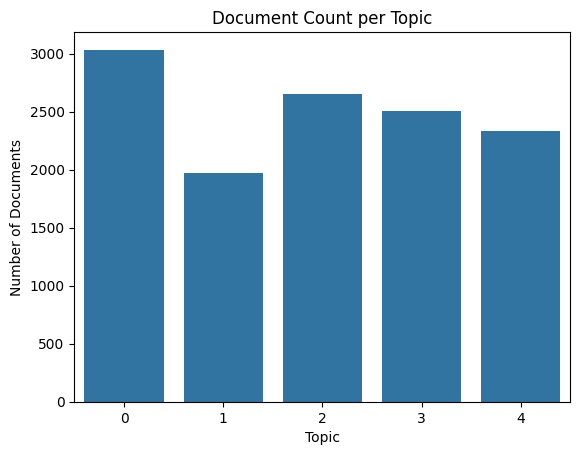

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df_final, x="dominant_topic")
plt.title("Document Count per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.show()

## Step 9: Topic–Emotion Association Analysis

## Step 9.1: Check DF

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   post_id         12495 non-null  object 
 1   created_date    12495 non-null  object 
 2   text            12495 non-null  object 
 3   emotion_label   12495 non-null  object 
 4   month           12495 non-null  object 
 5   year            12495 non-null  int64  
 6   source          12495 non-null  object 
 7   date            12495 non-null  object 
 8   processed_text  12495 non-null  object 
 9   dominant_topic  12495 non-null  int64  
 10  topic_0         12495 non-null  float64
 11  topic_1         12495 non-null  float64
 12  topic_2         12495 non-null  float64
 13  topic_3         12495 non-null  float64
 14  topic_4         12495 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 1.4+ MB


## Step 9.2: Group and count combinations

In [ ]:
# Count how many times each emotion appears in each topic
topic_emotion_counts = df_final.groupby(["dominant_topic", "emotion_label"]).size().reset_index(name="count")

# Pivot table to create matrix: Topic (row) x Emotion (column)
topic_emotion_matrix = topic_emotion_counts.pivot(index="dominant_topic", columns="emotion_label", values="count").fillna(0)

# View result
topic_emotion_matrix

emotion_label,anger,disgust,fear,joy,neutral,sadness,surprise
dominant_topic,,,,,,,
0,586,442,104,120,1370,107,304
1,318,284,77,91,948,119,135
2,455,449,130,57,1254,99,207
3,428,443,88,113,1089,129,219
4,346,193,73,62,1423,62,171


## Step 9.3: Normalize

In [ ]:
# Normalize per topic (row) to see emotion percentage
topic_emotion_distribution = topic_emotion_matrix.div(topic_emotion_matrix.sum(axis=1), axis=0)

# View normalized distribution
topic_emotion_distribution

emotion_label,anger,disgust,fear,joy,neutral,sadness,surprise
dominant_topic,,,,,,,
0,0.193208,0.145730,0.034289,0.039565,0.451698,0.035279,0.100231
1,0.161258,0.144016,0.039047,0.046146,0.480730,0.060345,0.068458
2,0.171633,0.169370,0.049038,0.021501,0.473029,0.037344,0.078084
3,0.170586,0.176564,0.035074,0.045038,0.434037,0.051415,0.087286
4,0.148498,0.082833,0.031330,0.026609,0.610730,0.026609,0.073391


## Step 9.4: Visualize (Bar chart or Heatmap)

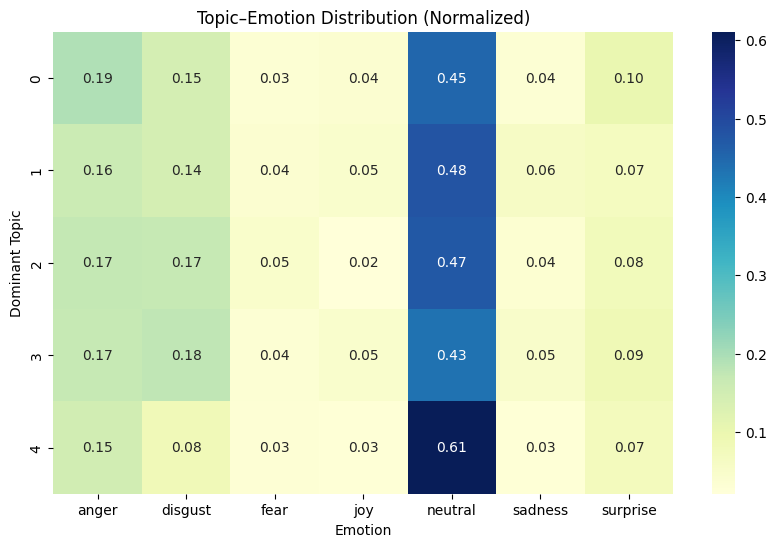

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_emotion_distribution, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Topic–Emotion Distribution (Normalized)")
plt.xlabel("Emotion")
plt.ylabel("Dominant Topic")
plt.show()

# 4. Timeseries Sentiment Analysis

## Daily Emotion Trend

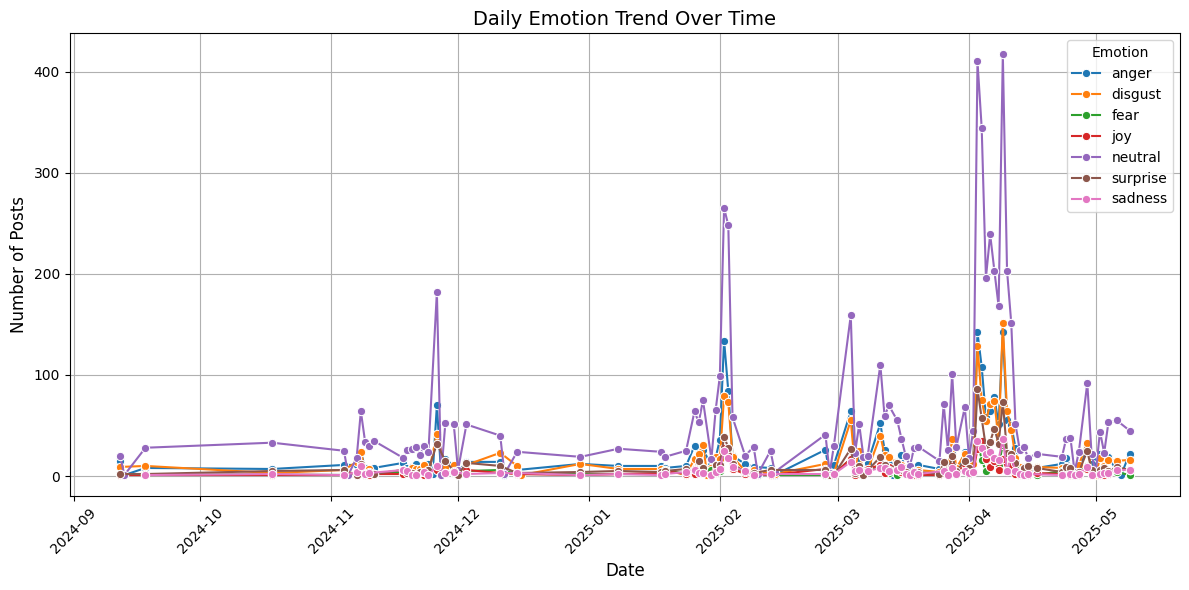

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'created_date' to datetime (if not already)
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")

# Extract date only (without time)
df_final["date"] = df_final["created_date"].dt.date

# Group by date and emotion label to count occurrences
daily_emotion_counts = (
    df_final.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# Plot daily emotion trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_emotion_counts,
    x="date",
    y="count",
    hue="emotion_label",
    marker="o"
)

# Plot formatting
plt.title("Daily Emotion Trend Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

event

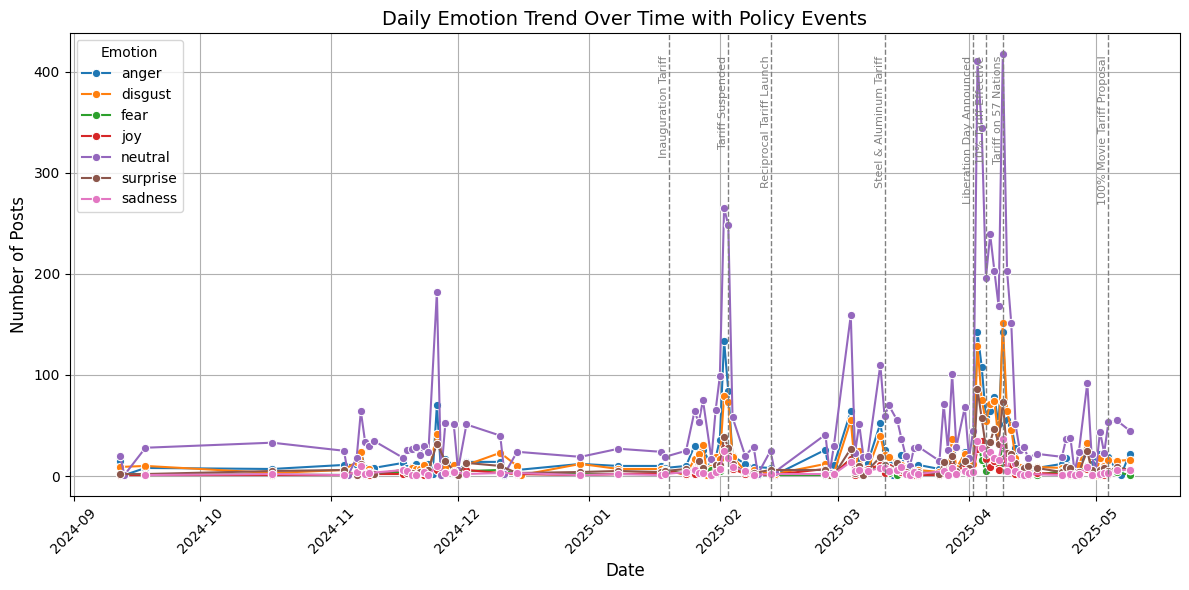

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Convert 'created_date' to datetime and extract date
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.date

# Step 2: Group by date and emotion label to count occurrences
daily_emotion_counts = (
    df_final.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# Step 3: Define policy events to overlay
policy_events = {
    "Inauguration Tariff": "2025-01-20",
    "Tariff Suspended": "2025-02-03",
    "Reciprocal Tariff Launch": "2025-02-13",
    "Steel & Aluminum Tariff": "2025-03-12",
    "Liberation Day Announced": "2025-04-02",
    "10% Tariff Effective": "2025-04-05",
    "Tariff on 57 Nations": "2025-04-09",
    "100% Movie Tariff Proposal": "2025-05-04"
}
policy_events = {name: pd.to_datetime(date).date() for name, date in policy_events.items()}

# Step 4: Plot daily emotion trend
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_emotion_counts,
    x="date",
    y="count",
    hue="emotion_label",
    marker="o"
)

# Step 5: Add vertical lines and annotations for events
for label, event_date in policy_events.items():
    plt.axvline(x=event_date, color="gray", linestyle="--", linewidth=1)
    plt.text(
        x=event_date,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        fontsize=8,
        color="gray",
        ha="right",
        va="top"
    )

# Step 6: Final formatting
plt.title("Daily Emotion Trend Over Time with Policy Events", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

## Daily Emotion Trend Plot (Excluding Neutral)

<ipython-input-39-dda8dc640378>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["date"] = df_filtered["created_date"].dt.date


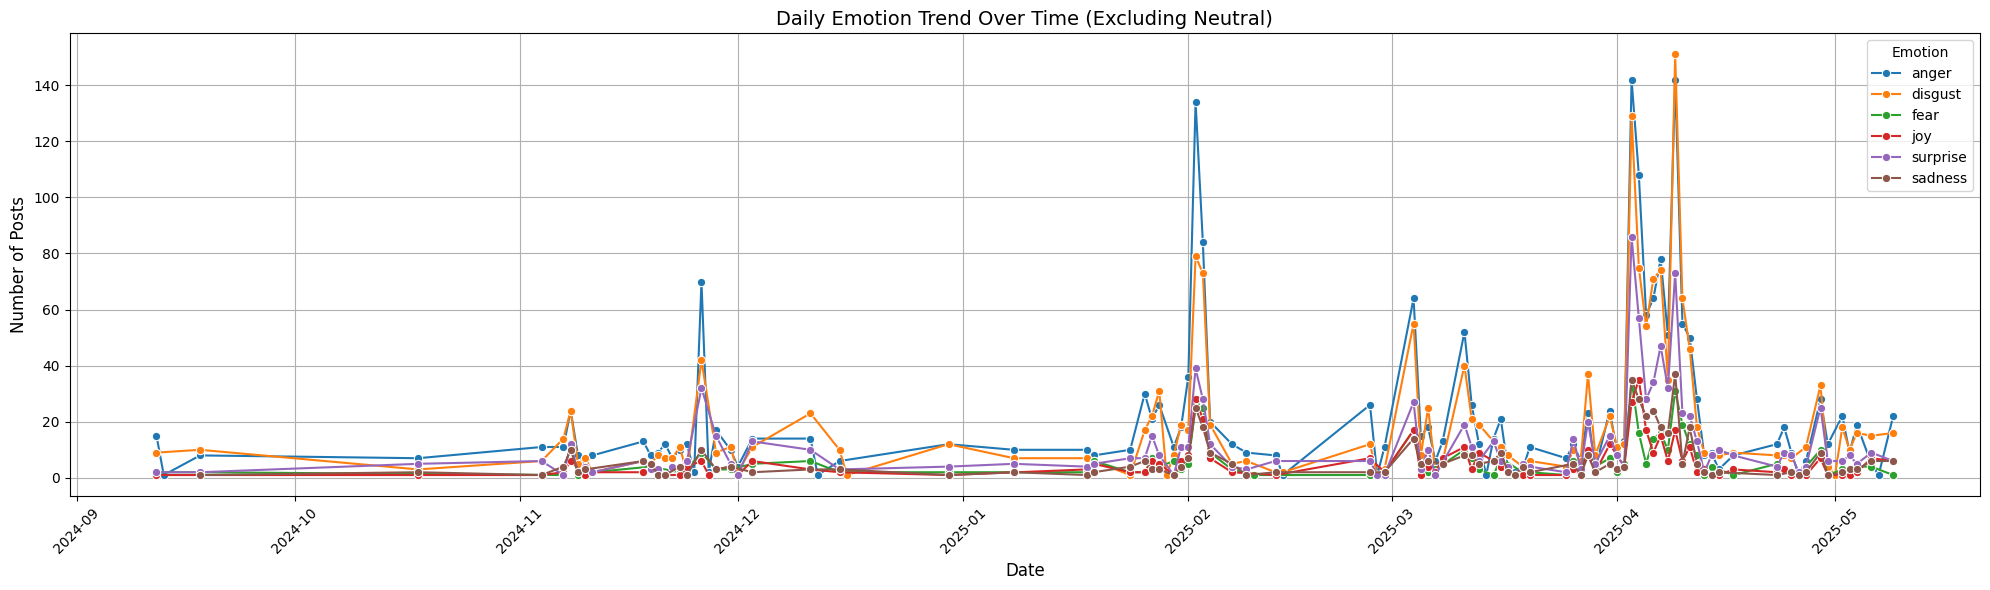

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert 'created_date' to datetime (if not already)
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")

# Step 2: Filter out rows labeled as 'neutral'
df_filtered = df_final[df_final["emotion_label"] != "neutral"]

# Step 3: Extract the date portion (ignore timestamp)
df_filtered["date"] = df_filtered["created_date"].dt.date

# Step 4: Group by date and emotion to count daily occurrences
daily_emotion_counts = (
    df_filtered.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# Step 5: Plot the daily trend line (non-neutral emotions)
plt.figure(figsize=(20, 6))
sns.lineplot(
    data=daily_emotion_counts,
    x="date",
    y="count",
    hue="emotion_label",
    marker="o"
)

# Formatting
plt.title("Daily Emotion Trend Over Time (Excluding Neutral)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

<ipython-input-21-f99e3931b637>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["date"] = df_filtered["created_date"].dt.date


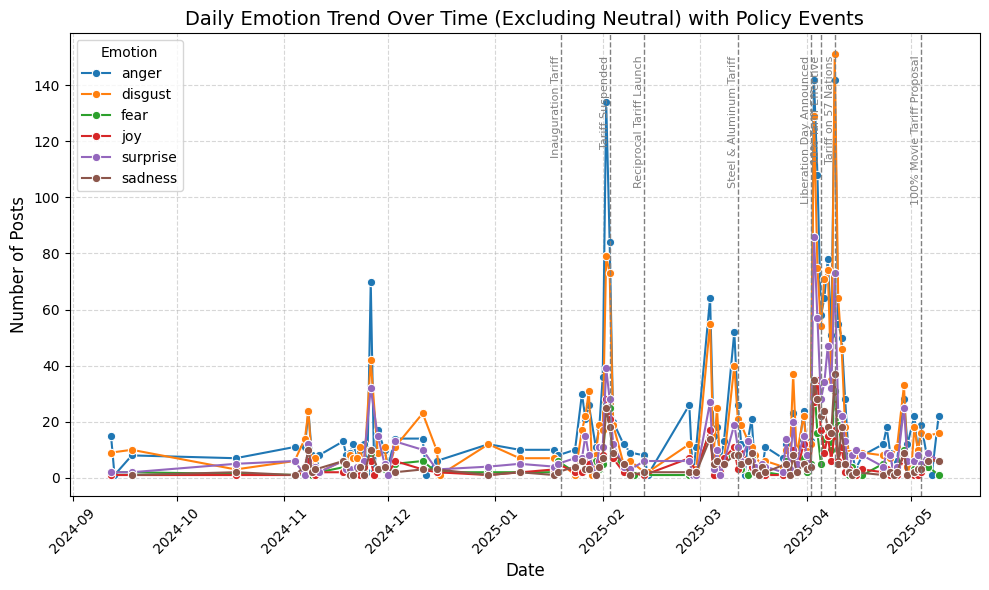

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Convert 'created_date' to datetime
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")

# Step 2: Filter out 'neutral' emotions
df_filtered = df_final[df_final["emotion_label"] != "neutral"]

# Step 3: Extract daily date
df_filtered["date"] = df_filtered["created_date"].dt.date

# Step 4: Group by date and emotion to count daily occurrences
daily_emotion_counts = (
    df_filtered.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# Step 5: Define policy event dates
policy_events = {
    "Inauguration Tariff": "2025-01-20",
    "Tariff Suspended": "2025-02-03",
    "Reciprocal Tariff Launch": "2025-02-13",
    "Steel & Aluminum Tariff": "2025-03-12",
    "Liberation Day Announced": "2025-04-02",
    "10% Tariff Effective": "2025-04-05",
    "Tariff on 57 Nations": "2025-04-09",
    "100% Movie Tariff Proposal": "2025-05-04"
}
policy_events = {event: pd.to_datetime(date).date() for event, date in policy_events.items()}

# Step 6: Plot emotion trend
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=daily_emotion_counts,
    x="date",
    y="count",
    hue="emotion_label",
    marker="o"
)

# Step 7: Add vertical event markers
for label, event_date in policy_events.items():
    plt.axvline(x=event_date, color="gray", linestyle="--", linewidth=1)
    plt.text(
        x=event_date,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        fontsize=8,
        color="gray",
        ha="right",
        va="top"
    )

# Step 8: Final formatting
plt.title("Daily Emotion Trend Over Time (Excluding Neutral) with Policy Events", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

## Monthly Emotion Distribution (%), Stacked Bar Chart

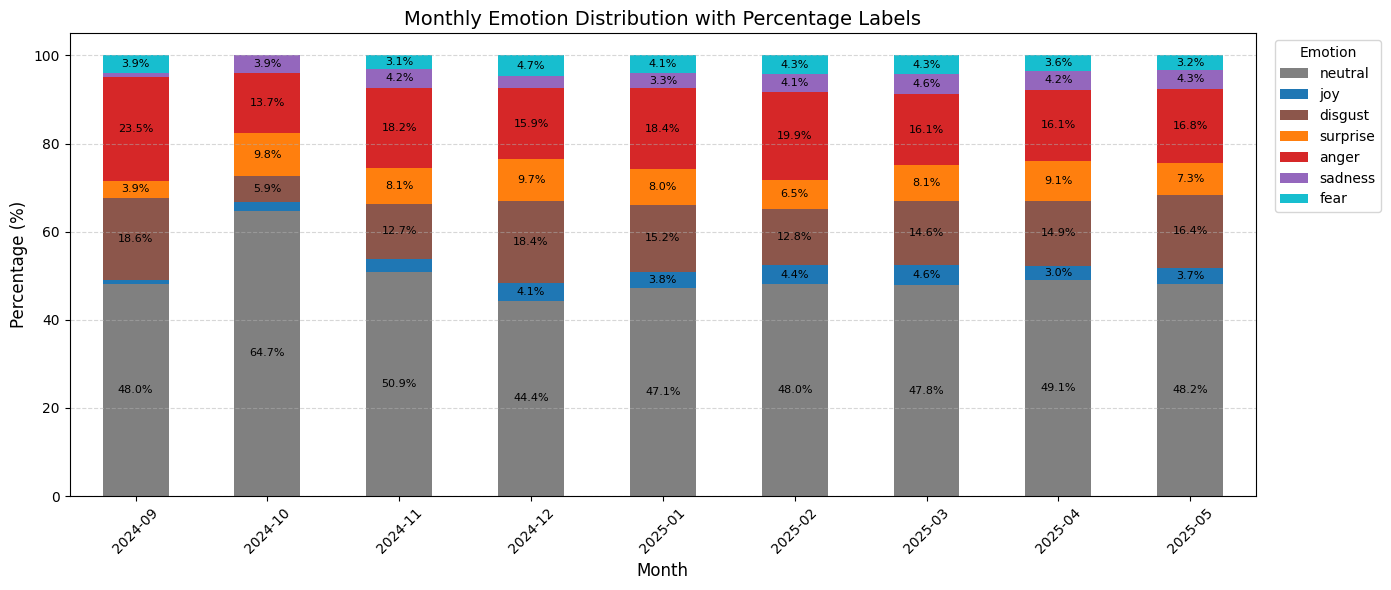

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define emotion display order and colors
ordered_emotions = ["neutral", "joy", "disgust", "surprise", "anger", "sadness", "fear"]
color_map = {
    "neutral": "gray",
    "joy": "#1f77b4",
    "disgust": "#8c564b",
    "surprise": "#ff7f0e",
    "anger": "#d62728",
    "sadness": "#9467bd",
    "fear": "#17becf"
}

# 2. Ensure created_date is datetime and extract 'month' in 'YYYY-MM' format
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["month"] = df_final["created_date"].dt.to_period("M").astype(str)

# 3. Count emotion occurrences per month
monthly_emotion_counts = (
    df_final.groupby(["month", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# 4. Compute emotion percentage per month
monthly_totals = monthly_emotion_counts.groupby("month")["count"].sum().reset_index(name="total")
monthly_emotion_ratio = monthly_emotion_counts.merge(monthly_totals, on="month")
monthly_emotion_ratio["percentage"] = monthly_emotion_ratio["count"] / monthly_emotion_ratio["total"] * 100

# 5. Pivot to a monthly-emotion matrix with ordered columns
pivot_ordered = (
    monthly_emotion_ratio.pivot(index="month", columns="emotion_label", values="percentage")
    .fillna(0)
)
pivot_ordered = pivot_ordered[[col for col in ordered_emotions if col in pivot_ordered.columns]]
colors = [color_map[col] for col in pivot_ordered.columns]

# 6. Plot stacked bar chart
ax = pivot_ordered.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    color=colors
)

plt.title("Monthly Emotion Distribution with Percentage Labels", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Emotion", bbox_to_anchor=(1.01, 1), loc="upper left")

# 7. Add percentage labels to segments above 3%
for i, (index, row) in enumerate(pivot_ordered.iterrows()):
    cumulative = 0
    for col in pivot_ordered.columns:
        height = row[col]
        if height > 3:
            ax.text(i, cumulative + height / 2, f"{height:.1f}%", ha="center", va="center", fontsize=8)
        cumulative += height

plt.tight_layout()
plt.show()

## Emotion Distribution Pie Chart (Overall Percentages)

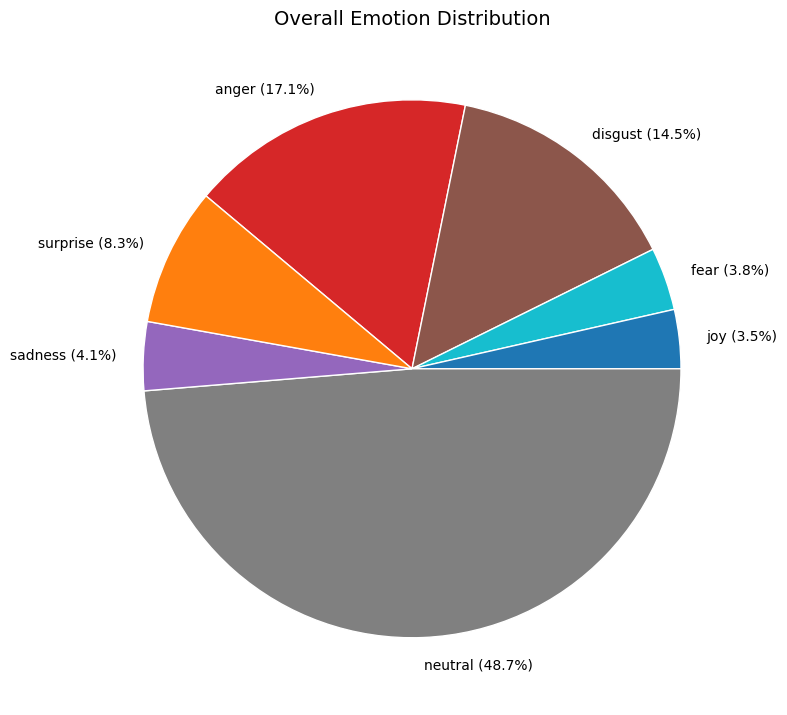

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 1. Count total number of posts per emotion
emotion_counts = df_final["emotion_label"].value_counts().sort_index()

# ✅ 2. Convert to percentage
emotion_percentages = emotion_counts / emotion_counts.sum() * 100

# ✅ 3. Create labels
labels = [f"{emotion} ({pct:.1f}%)" for emotion, pct in zip(emotion_percentages.index, emotion_percentages.values)]

# ✅ 4. Define custom color map (optional)
color_map = {
    "neutral": "gray",
    "joy": "#1f77b4",
    "disgust": "#8c564b",
    "surprise": "#ff7f0e",
    "anger": "#d62728",
    "sadness": "#9467bd",
    "fear": "#17becf"
}
colors = [color_map.get(emotion, "#cccccc") for emotion in emotion_percentages.index]

# ✅ 5. Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_percentages,
    labels=labels,
    colors=colors,
    startangle=140,
    counterclock=False,
    wedgeprops={"edgecolor": "white"}
)

plt.title("Overall Emotion Distribution", fontsize=14)
plt.tight_layout()
plt.show()


## Topic Evolution Over Time

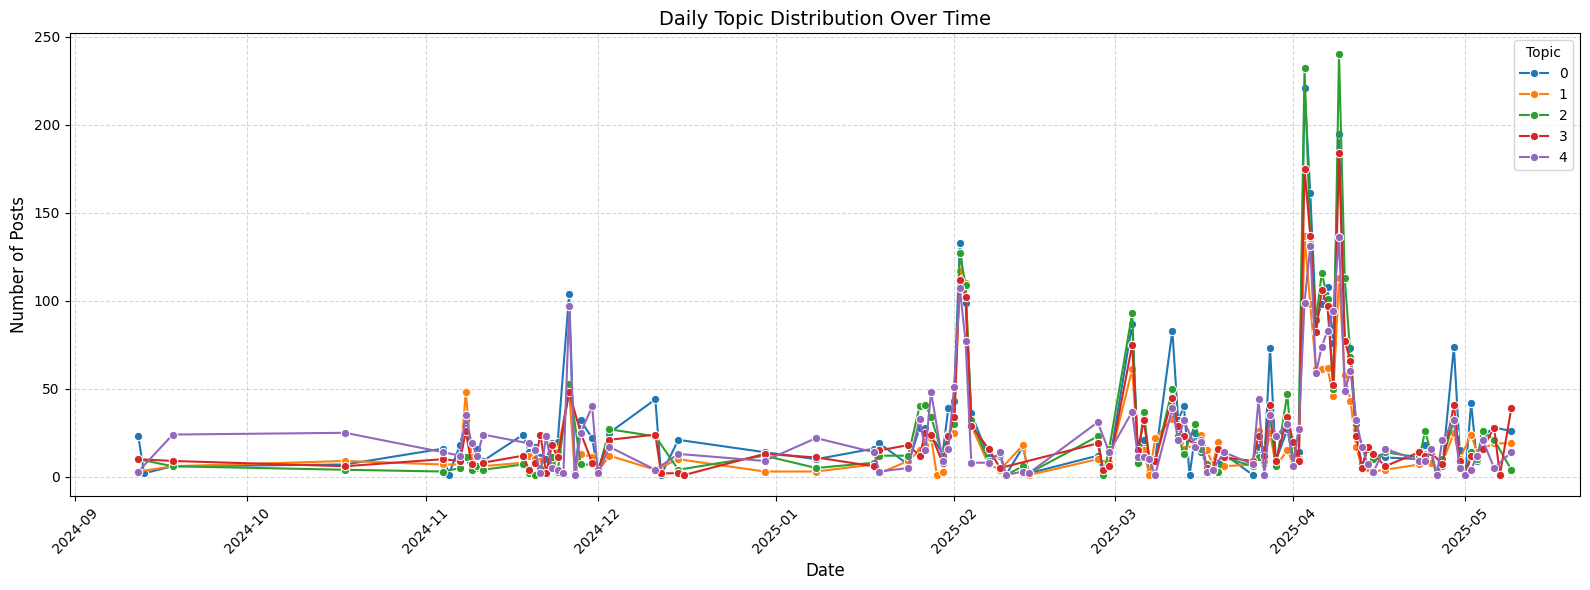

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 1. Ensure 'created_date' is datetime and extract date
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.date

# ✅ 2. Count posts per topic per day
daily_topic_counts = (
    df_final.groupby(["date", "dominant_topic"])
    .size()
    .reset_index(name="count")
)

# ✅ 3. Prepare color palette (adjust to match your topic count)
num_topics = df_final["dominant_topic"].nunique()
palette = sns.color_palette("tab10", n_colors=num_topics)  # alternatives: "Set1", "husl", etc.

# ✅ 4. Plot line chart with distinct colors
plt.figure(figsize=(16, 6))
sns.lineplot(
    data=daily_topic_counts,
    x="date",
    y="count",
    hue="dominant_topic",
    palette=palette,
    marker="o"
)

# ✅ 5. Final formatting
plt.title("Daily Topic Distribution Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Topic")
plt.tight_layout()
plt.show()


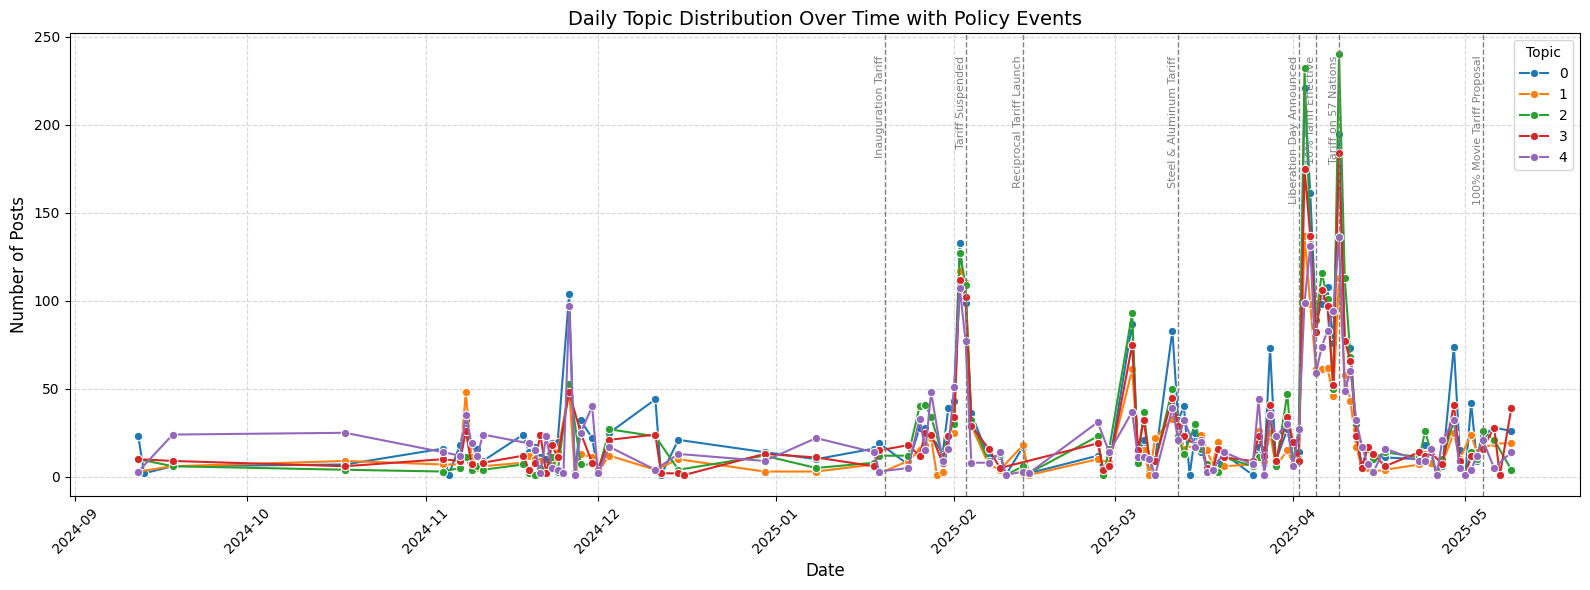

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Ensure 'created_date' is datetime and extract date
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.date

# Step 2: Count posts per topic per day
daily_topic_counts = (
    df_final.groupby(["date", "dominant_topic"])
    .size()
    .reset_index(name="count")
)

# Step 3: Define policy events
policy_events = {
    "Inauguration Tariff": "2025-01-20",
    "Tariff Suspended": "2025-02-03",
    "Reciprocal Tariff Launch": "2025-02-13",
    "Steel & Aluminum Tariff": "2025-03-12",
    "Liberation Day Announced": "2025-04-02",
    "10% Tariff Effective": "2025-04-05",
    "Tariff on 57 Nations": "2025-04-09",
    "100% Movie Tariff Proposal": "2025-05-04"
}
policy_events = {event: pd.to_datetime(date).date() for event, date in policy_events.items()}

# Step 4: Prepare color palette for topics
num_topics = df_final["dominant_topic"].nunique()
palette = sns.color_palette("tab10", n_colors=num_topics)

# Step 5: Plot topic trend
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_topic_counts,
    x="date",
    y="count",
    hue="dominant_topic",
    palette=palette,
    marker="o"
)

# Step 6: Overlay event lines and labels
for label, event_date in policy_events.items():
    plt.axvline(x=event_date, color="gray", linestyle="--", linewidth=1)
    plt.text(
        x=event_date,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        fontsize=8,
        color="gray",
        ha="right",
        va="top"
    )

# Step 7: Final formatting
plt.title("Daily Topic Distribution Over Time with Policy Events", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Topic")
plt.tight_layout()
plt.show()

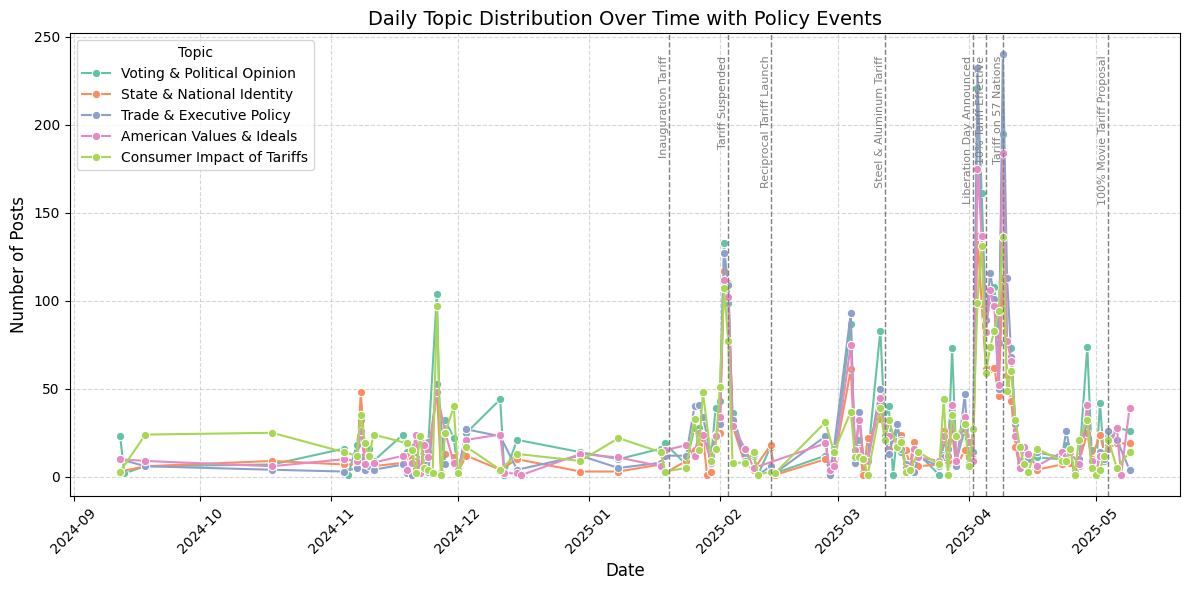

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure datetime and date
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.date

# Group by date and topic
daily_topic_counts = (
    df_final.groupby(["date", "dominant_topic"])
    .size()
    .reset_index(name="count")
)

# Define semantic topic labels
topic_labels = {
    0: "Voting & Political Opinion",
    1: "State & National Identity",
    2: "Trade & Executive Policy",
    3: "American Values & Ideals",
    4: "Consumer Impact of Tariffs"
}

# Map labels into a new column
daily_topic_counts["topic_label"] = daily_topic_counts["dominant_topic"].map(topic_labels)

# Define policy events
policy_events = {
    "Inauguration Tariff": "2025-01-20",
    "Tariff Suspended": "2025-02-03",
    "Reciprocal Tariff Launch": "2025-02-13",
    "Steel & Aluminum Tariff": "2025-03-12",
    "Liberation Day Announced": "2025-04-02",
    "10% Tariff Effective": "2025-04-05",
    "Tariff on 57 Nations": "2025-04-09",
    "100% Movie Tariff Proposal": "2025-05-04"
}
policy_events = {event: pd.to_datetime(date).date() for event, date in policy_events.items()}

# Prepare color palette
num_topics = len(topic_labels)
palette = sns.color_palette("Set2", n_colors=num_topics)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_topic_counts,
    x="date",
    y="count",
    hue="topic_label",
    palette=palette,
    marker="o"
)

# Add policy event lines
for label, event_date in policy_events.items():
    plt.axvline(x=event_date, color="gray", linestyle="--", linewidth=1)
    plt.text(
        x=event_date,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        fontsize=8,
        color="gray",
        ha="right",
        va="top"
    )

# Format plot
plt.title("Daily Topic Distribution Over Time with Policy Events", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Topic")
plt.tight_layout()
plt.show()


# Specific Event

In [ ]:
import pandas as pd

# Convert 'created_date' to datetime and extract daily date
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.floor("D")

# Group by date and emotion label, count occurrences
daily_emotion_freq = (
    df_final.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# Pivot table to create a date × emotion count matrix
daily_emotion_pivot = (
    daily_emotion_freq
    .pivot(index="date", columns="emotion_label", values="count")
    .fillna(0)
)

# Compute composite emotion indices
daily_emotion_pivot["polarization_index"] = (
    daily_emotion_pivot.get("anger", 0)
    + daily_emotion_pivot.get("sadness", 0)
    + daily_emotion_pivot.get("disgust", 0)
    - daily_emotion_pivot.get("joy", 0)
    - daily_emotion_pivot.get("optimism", 0)
)

daily_emotion_pivot["anxiety_index"] = (
    daily_emotion_pivot.get("anger", 0)
    + daily_emotion_pivot.get("fear", 0)
)

# Compute total daily emotional expressions
daily_emotion_pivot["total"] = daily_emotion_pivot.sum(axis=1)

# Calculate anger ratio as a percentage
daily_emotion_pivot["anger_ratio"] = (
    daily_emotion_pivot.get("anger", 0) / daily_emotion_pivot["total"] * 100
)

# Preview result
daily_emotion_pivot.head()

emotion_label,anger,disgust,fear,joy,neutral,sadness,surprise,polarization_index,anxiety_index,total,anger_ratio
date,,,,,,,,,,,
2024-09-12,15.0,9.0,2.0,1.0,20.0,0.0,2.0,23.0,17.0,89.0,16.853933
2024-09-13,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,25.000000
2024-09-18,8.0,10.0,2.0,0.0,28.0,1.0,2.0,19.0,10.0,80.0,10.000000
2024-10-18,7.0,3.0,0.0,1.0,33.0,2.0,5.0,11.0,7.0,69.0,10.144928
2024-11-04,11.0,6.0,0.0,1.0,25.0,1.0,6.0,17.0,11.0,78.0,14.102564


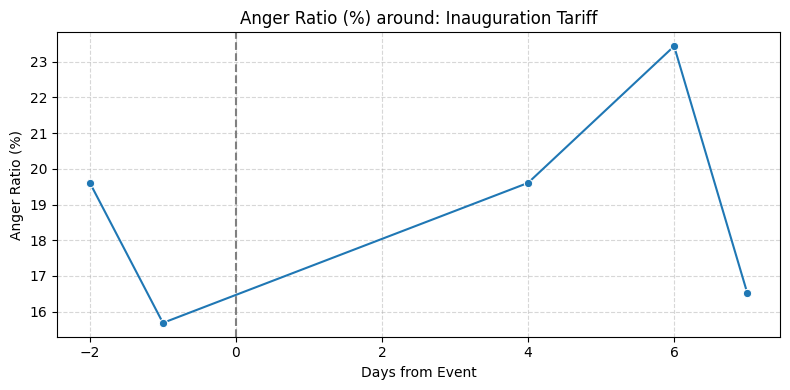

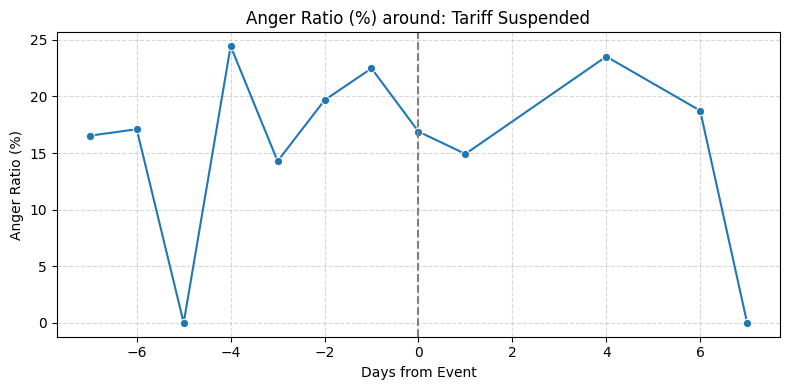

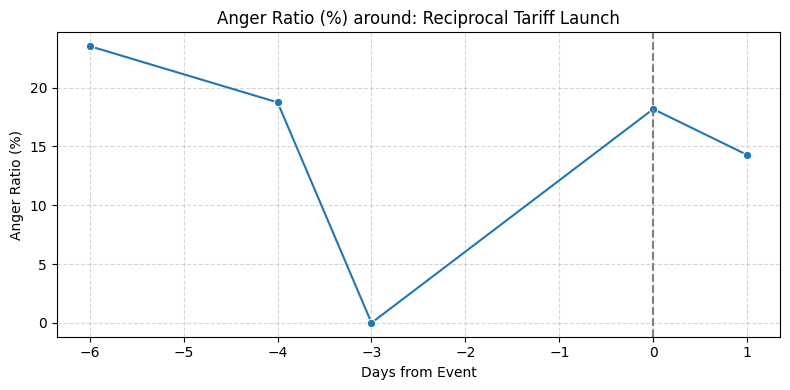

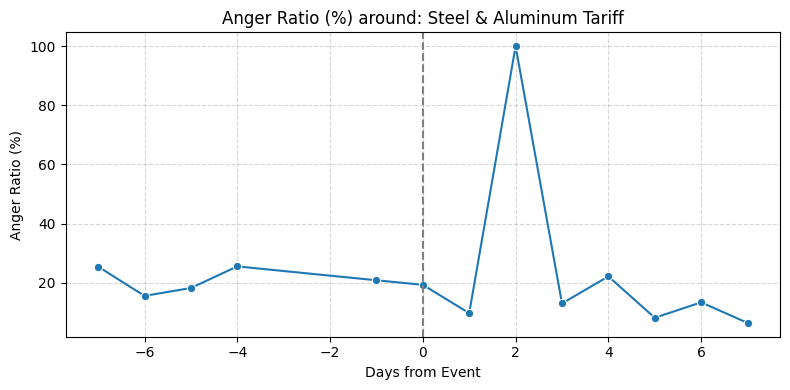

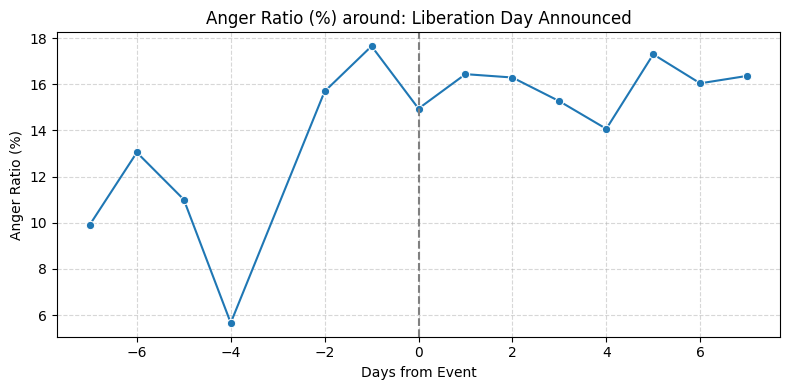

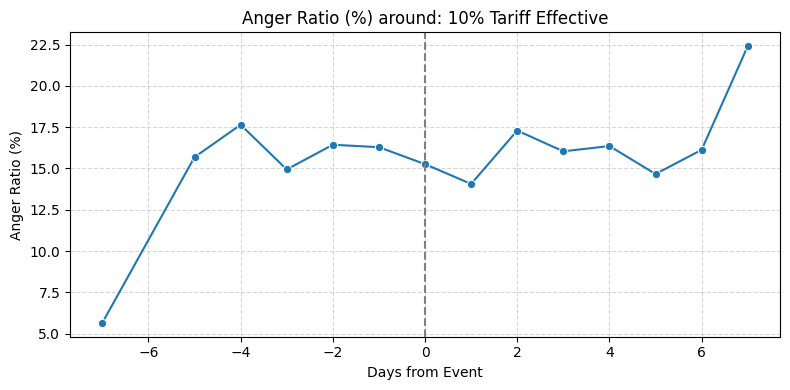

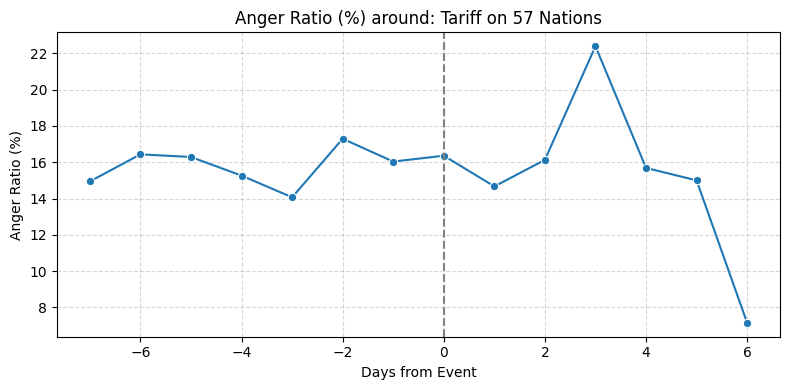

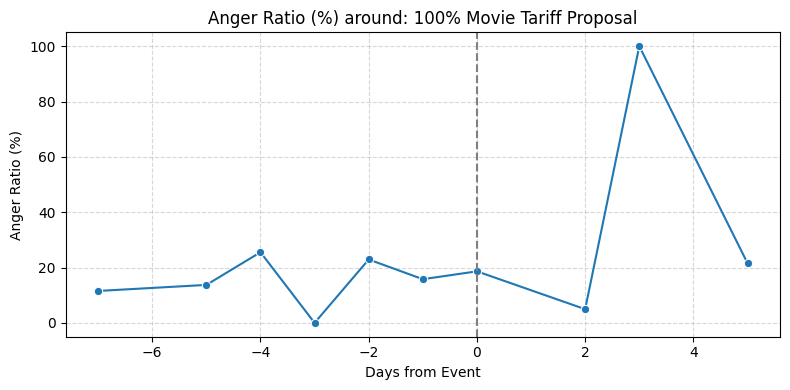

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert created_date to datetime and extract date
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.floor("D")

# Recalculate daily emotion counts
daily_emotion_freq = (
    df_final.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)

# Pivot to a daily emotion matrix
daily_emotion_pivot = (
    daily_emotion_freq.pivot(index="date", columns="emotion_label", values="count")
    .fillna(0)
)

# Compute anger ratio per day
daily_emotion_pivot["total"] = daily_emotion_pivot.sum(axis=1)
daily_emotion_pivot["anger_ratio"] = (
    daily_emotion_pivot.get("anger", 0) / daily_emotion_pivot["total"] * 100
)

# Define key policy events
policy_events = pd.DataFrame([
    {"event": "Inauguration Tariff", "date": "2025-01-20"},
    {"event": "Tariff Suspended", "date": "2025-02-03"},
    {"event": "Reciprocal Tariff Launch", "date": "2025-02-13"},
    {"event": "Steel & Aluminum Tariff", "date": "2025-03-12"},
    {"event": "Liberation Day Announced", "date": "2025-04-02"},
    {"event": "10% Tariff Effective", "date": "2025-04-05"},
    {"event": "Tariff on 57 Nations", "date": "2025-04-09"},
    {"event": "100% Movie Tariff Proposal", "date": "2025-05-04"},
])
policy_events["date"] = pd.to_datetime(policy_events["date"])

# Plot one chart per event with a ±7 day window
for _, row in policy_events.iterrows():
    event = row["event"]
    event_date = row["date"]
    start = event_date - pd.Timedelta(days=7)
    end = event_date + pd.Timedelta(days=7)

    # Slice daily data for this window
    sliced = daily_emotion_pivot.loc[start:end].copy()
    sliced["day"] = pd.to_datetime(sliced.index)
    sliced["days_from_event"] = (sliced["day"] - event_date).dt.days

    # Plot anger ratio around the event
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=sliced, x="days_from_event", y="anger_ratio", marker="o")
    plt.axvline(0, color="gray", linestyle="--")
    plt.title(f"Anger Ratio (%) around: {event}")
    plt.xlabel("Days from Event")
    plt.ylabel("Anger Ratio (%)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

## Emotion Ratio Trends Around Events (±14 Days)

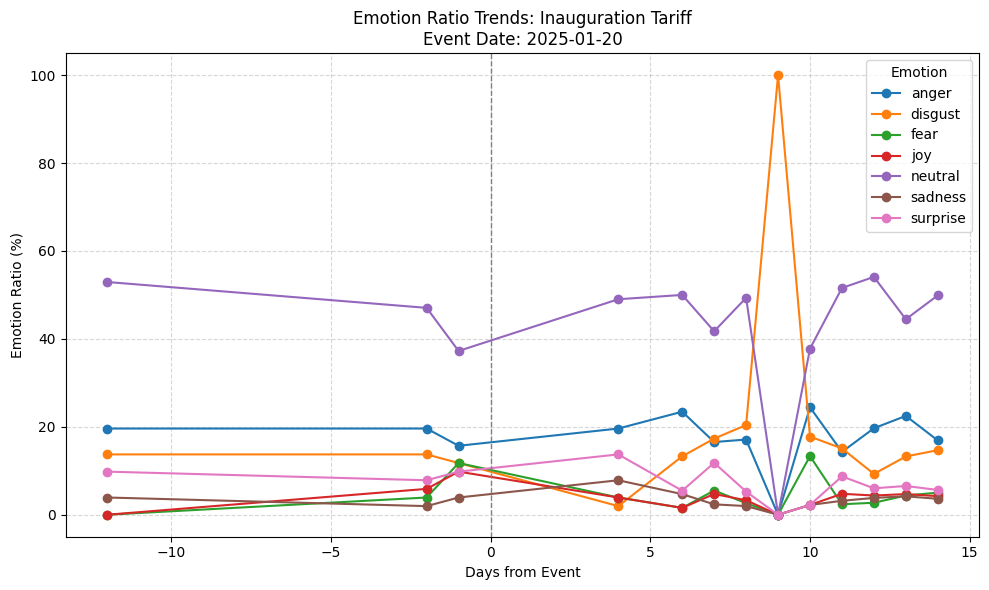

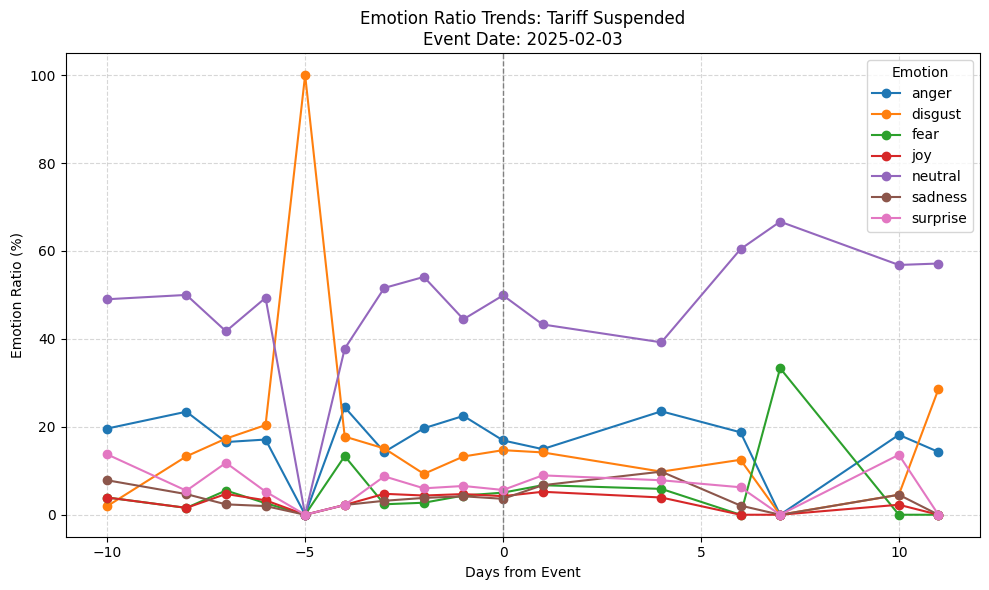

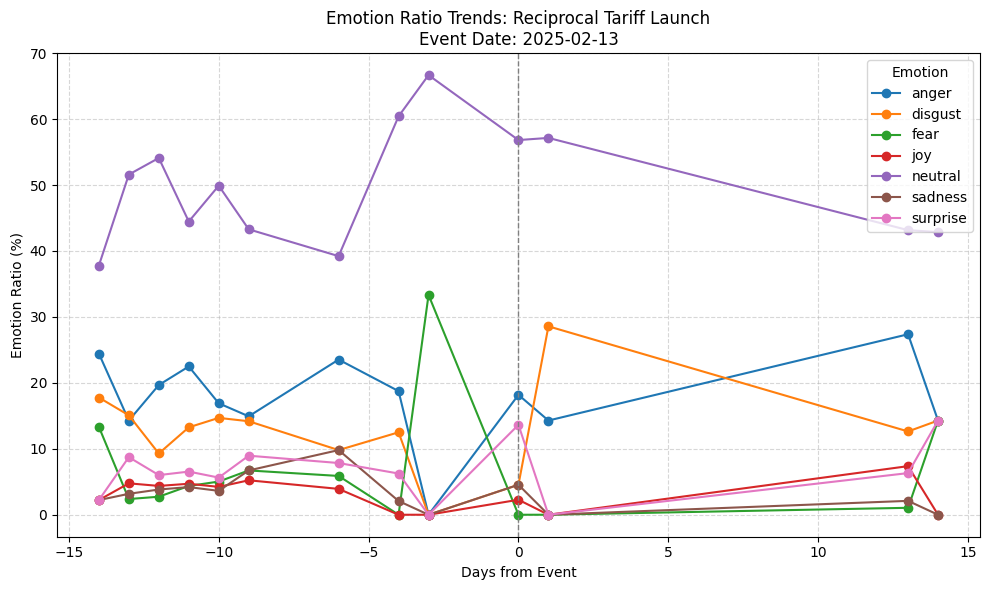

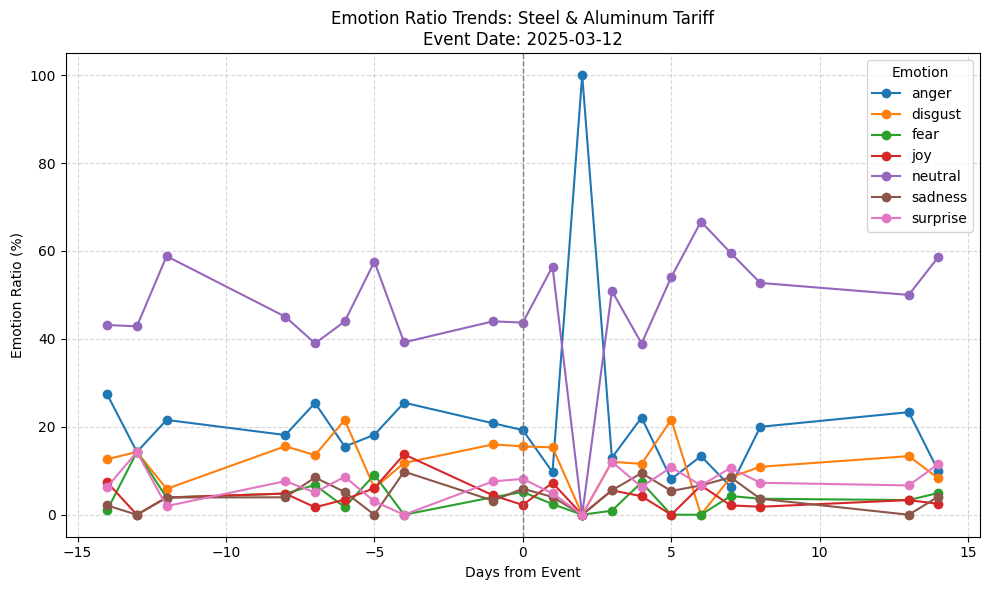

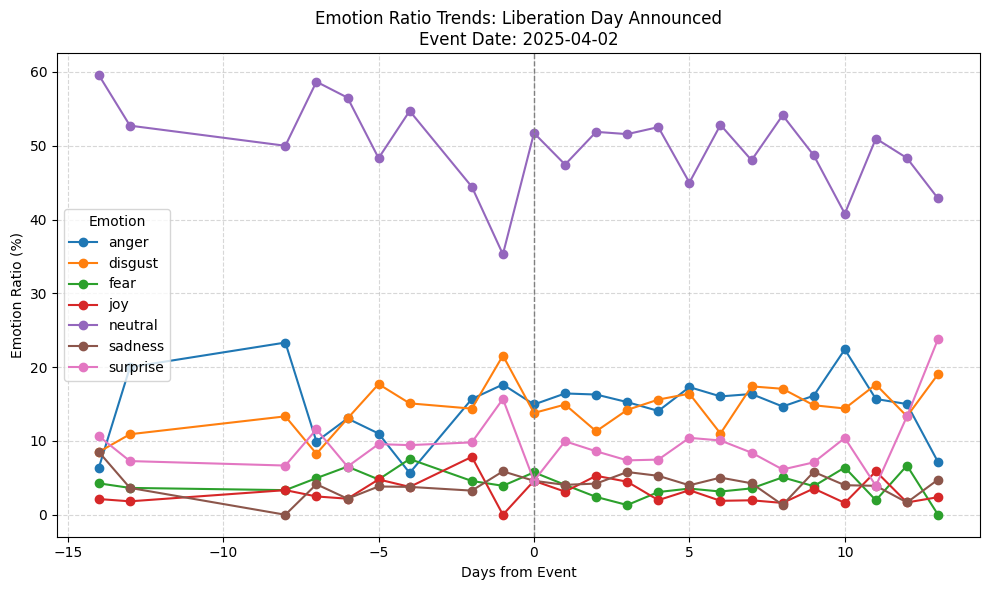

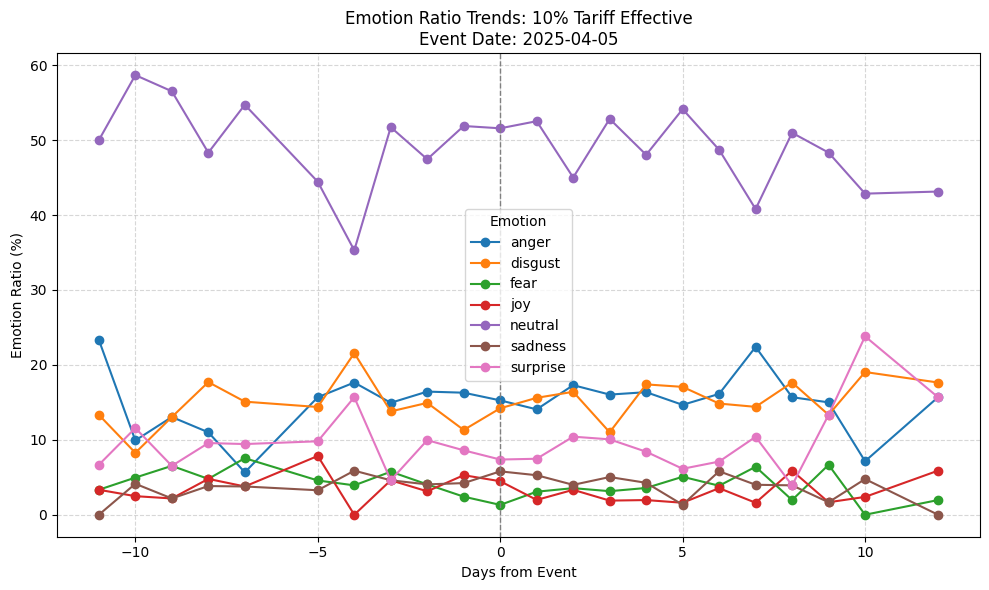

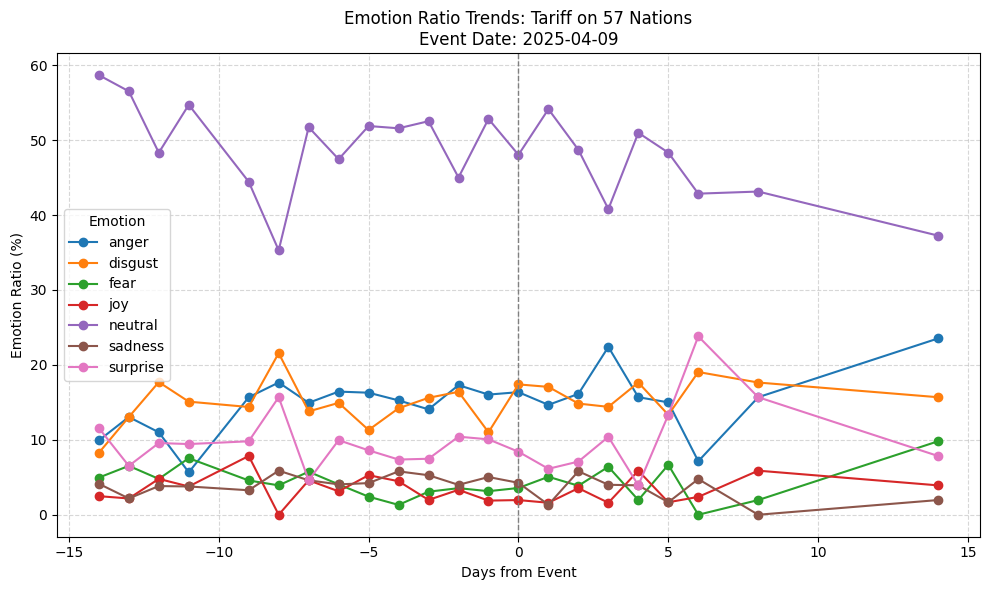

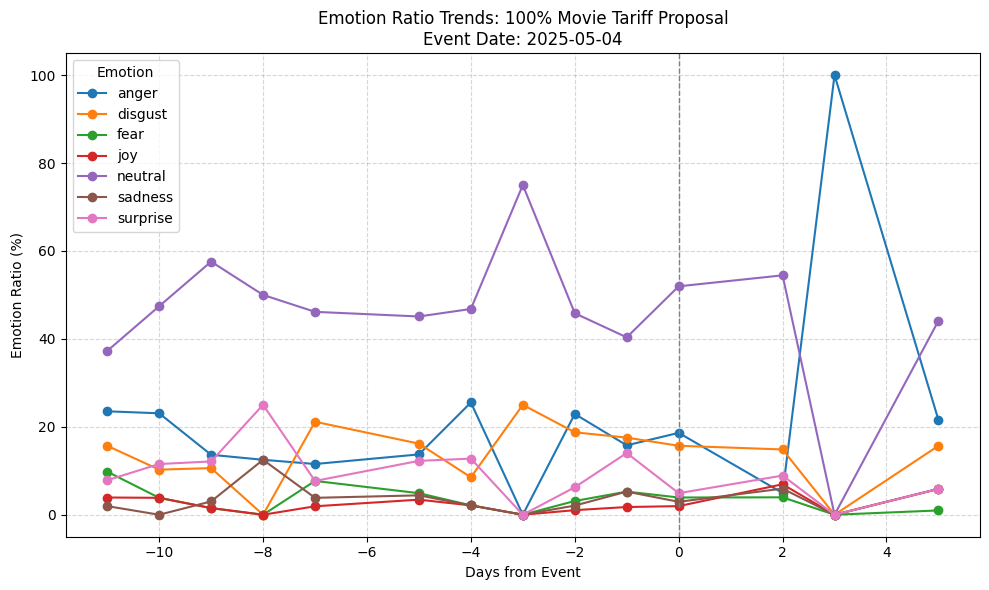

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare datetime columns
df_final["created_date"] = pd.to_datetime(df_final["created_date"], errors="coerce")
df_final["date"] = df_final["created_date"].dt.floor("D")

# Step 2: Aggregate daily emotion counts
daily_emotion_freq = (
    df_final.groupby(["date", "emotion_label"])
    .size()
    .reset_index(name="count")
)
daily_emotion_pivot = daily_emotion_freq.pivot(index="date", columns="emotion_label", values="count").fillna(0)

# Step 3: Calculate emotion ratios
daily_emotion_pivot["total"] = daily_emotion_pivot.sum(axis=1)
emotion_columns = [col for col in daily_emotion_pivot.columns if col != "total"]

for emotion in emotion_columns:
    daily_emotion_pivot[f"{emotion}_ratio"] = (
        daily_emotion_pivot[emotion] / daily_emotion_pivot["total"] * 100
    )

# Step 4: Define key policy events
policy_events = pd.DataFrame([
    {"event": "Inauguration Tariff", "date": "2025-01-20"},
    {"event": "Tariff Suspended", "date": "2025-02-03"},
    {"event": "Reciprocal Tariff Launch", "date": "2025-02-13"},
    {"event": "Steel & Aluminum Tariff", "date": "2025-03-12"},
    {"event": "Liberation Day Announced", "date": "2025-04-02"},
    {"event": "10% Tariff Effective", "date": "2025-04-05"},
    {"event": "Tariff on 57 Nations", "date": "2025-04-09"},
    {"event": "100% Movie Tariff Proposal", "date": "2025-05-04"},
])
policy_events["date"] = pd.to_datetime(policy_events["date"])

# Step 5: Create ±14 day windows around each event
df_ratio_trends = []
for _, row in policy_events.iterrows():
    event_name = row["event"]
    event_date = row["date"]
    start = event_date - pd.Timedelta(days=14)
    end = event_date + pd.Timedelta(days=14)

    sliced = daily_emotion_pivot.loc[start:end].copy()
    sliced["day"] = pd.to_datetime(sliced.index)
    sliced["event"] = event_name
    sliced["days_from_event"] = (sliced["day"] - event_date).dt.days

    df_ratio_trends.append(sliced)

df_ratio_trends = pd.concat(df_ratio_trends)

# Step 6: Plot emotion ratio trends for each event
emotion_ratios = [col for col in df_ratio_trends.columns if col.endswith("_ratio")]
emotion_names = [e.replace("_ratio", "") for e in emotion_ratios]

for event in policy_events["event"]:
    data = df_ratio_trends[df_ratio_trends["event"] == event]

    plt.figure(figsize=(10, 6))
    for emotion in emotion_names:
        if f"{emotion}_ratio" in data.columns:
            plt.plot(
                data["days_from_event"],
                data[f"{emotion}_ratio"],
                label=emotion,
                marker='o'
            )
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)
    event_date_str = policy_events[policy_events["event"] == event]["date"].dt.strftime("%Y-%m-%d").values[0]
    plt.title(f"Emotion Ratio Trends: {event}\nEvent Date: {event_date_str}")
    plt.xlabel("Days from Event")
    plt.ylabel("Emotion Ratio (%)")
    plt.legend(title="Emotion")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()